# CSPs
It covers all concepts of CSPs in AI, including definitions, types of constraints, consistency, and algorithms like backtracking and AC-3.


## 1. Constraint Satisfaction Problem (CSP)
A **CSP** is a problem defined by three components:

1. **Variables**: {X1, X2, ..., Xn} → things we need to assign values to.
2. **Domains**: {D1, D2, ..., Dn} → possible values for each variable.
3. **Constraints (C)**: rules that restrict which values are allowed.

## 2. Types of Constraints

### Hard Constraints
- Rules that **must** be satisfied in a correct solution.
- **Example**: Sudoku → each number appears only once in a row.

### Soft Constraints
- Rules that are **preferences**, not mandatory.
- Solutions are still valid if soft constraints are violated, but **better solutions satisfy more soft constraints**.
- **Example**: Prefer scheduling meetings in the morning, but evening is okay.


## 3. Types of Constraints by Variables Involved

### Unary Constraint
- Involves **only one variable**
- **Example**: A ≠ Red → Domain(A) becomes {Green, Blue}

### Binary Constraint
- Involves **two variables**
- **Example**: A ≠ B → neighbors must have different colors

### Global Constraint
- Involves **many variables**
- **Example**: Sudoku row must have all numbers 1–9


## 4. Consistency in CSPs

### Node Consistency
- A variable is node-consistent if **all values in its domain satisfy unary constraints**.
- **Example**: A's domain = {Red, Green, Blue}, Unary constraint A ≠ Red → Node consistent domain = {Green, Blue}

### Arc Consistency
- A variable X is arc-consistent with Y if **every value in X has at least one compatible value in Y**.
- **Example**: 
  - X = {Red, Green}, Y = {Red}, Constraint X ≠ Y
  - Red in X has no match in Y → remove Red
  - Arc-consistent X = {Green}


In [9]:
# REVISE function for enforcing arc consistency between X and Y
def REVISE(csp, X, Y):
    revised = False
    for x in csp['domains'][X][:]:  # copy of domain to iterate
        satisfies = False
        for y in csp['domains'][Y]:
            if (X, x, Y, y) not in csp['constraints']:  # if constraint not violated
                satisfies = True
                break
        if not satisfies:
            csp['domains'][X].remove(x)
            revised = True
    return revised


## 5. AC-3 Algorithm
**Purpose**: Make all variables arc-consistent before or during backtracking search.

**Steps**:
1. Initialize queue with all arcs in the CSP
2. While queue is not empty:
   - Take an arc (X, Y) from queue
   - Apply REVISE(X, Y)
   - If domain of X becomes empty → failure
   - If X’s domain changed → add neighbors of X (except Y) back to queue
3. If queue empties → CSP is arc-consistent


In [10]:
from collections import deque

def AC3(csp):
    queue = deque([(X,Y) for X in csp['variables'] for Y in csp['neighbors'][X]])
    while queue:
        X, Y = queue.popleft()
        if REVISE(csp, X, Y):
            if not csp['domains'][X]:  # domain empty
                return False
            for Z in csp['neighbors'][X]:
                if Z != Y:
                    queue.append((Z, X))
    return True


## 6. CSP as a Search Problem

- **Initial state**: empty assignment {}
- **Actions**: assign a value to a variable {X=value}
- **Transition model**: shows how assignment changes current assignment
- **Goal test**: all variables assigned and all constraints satisfied
- **Path cost**: usually all paths have the same cost (finding a solution is enough)


## 7. Backtracking Search Algorithm
- Assign a value to a variable
- Check consistency
- Recurse for next variable
- Backtrack if no value works

**Pseudocode**:

BACKTRACK(assignment, CSP)
if assignment complete → return assignment
var = SELECT-UNASSIGNED-VAR()
for value in DOMAIN-VALUES(var):
if consistent with assignment:
add {var=value} to assignment
result = BACKTRACK(assignment, CSP)
if result ≠ failure → return result
remove {var=value} from assignment
return failure

In [11]:
def is_consistent(var, value, assignment, csp):
    for neighbor in csp['neighbors'][var]:
        if neighbor in assignment and (var, value, neighbor, assignment[neighbor]) in csp['constraints']:
            return False
    return True

def BACKTRACK(assignment, csp):
    if len(assignment) == len(csp['variables']):
        return assignment
    
    # MRV heuristic: select unassigned variable with smallest domain
    unassigned_vars = [v for v in csp['variables'] if v not in assignment]
    var = min(unassigned_vars, key=lambda v: len(csp['domains'][v]))
    
    for value in csp['domains'][var]:
        if is_consistent(var, value, assignment, csp):
            assignment[var] = value
            # Optional: inference step can be added here (like AC3)
            result = BACKTRACK(assignment, csp)
            if result:
                return result
            del assignment[var]
    return None


## 8. Variable and Value Ordering Heuristics

### SELECT-UNASSIGNED-VAR
- **MRV (Minimum Remaining Values)**: pick variable with smallest domain
- **Degree Heuristic**: pick variable with most constraints on other unassigned variables

### DOMAIN-VALUES
- **Least-Constraining Value (LCV)**: pick value that rules out fewest choices for neighbors


### Example: Map Coloring CSP

- Variables = {A, B, C}
- Domains = {Red, Green, Blue}
- Constraints = neighbors cannot have same color
- Neighbors:
    A → B, C
    B → A, C
    C → A, B


In [12]:
# Example CSP dictionary
csp_example = {
    'variables': ['A', 'B', 'C'],
    'domains': {
        'A': ['Red', 'Green', 'Blue'],
        'B': ['Red', 'Green', 'Blue'],
        'C': ['Red', 'Green', 'Blue']
    },
    'neighbors': {
        'A': ['B', 'C'],
        'B': ['A', 'C'],
        'C': ['A', 'B']
    },
    # constraints are tuples (X, x, Y, y) that are **not allowed**
    'constraints': set([
        ('A','Red','B','Red'), ('A','Green','B','Green'), ('A','Blue','B','Blue'),
        ('A','Red','C','Red'), ('A','Green','C','Green'), ('A','Blue','C','Blue'),
        ('B','Red','C','Red'), ('B','Green','C','Green'), ('B','Blue','C','Blue'),
        # symmetric constraints
        ('B','Red','A','Red'), ('B','Green','A','Green'), ('B','Blue','A','Blue'),
        ('C','Red','A','Red'), ('C','Green','A','Green'), ('C','Blue','A','Blue'),
        ('C','Red','B','Red'), ('C','Green','B','Green'), ('C','Blue','B','Blue'),
    ])
}

# Solve CSP with Backtracking
solution = BACKTRACK({}, csp_example)
print("Solution:", solution)


Solution: {'A': 'Red', 'B': 'Green', 'C': 'Blue'}


## 9. Backtracking Search with Inference (MAC)

### Idea:
- Combine **backtracking search** with **constraint propagation** (inference).
- Every time we assign a value to a variable:
  1. Perform **inference** (like AC-3 or forward checking)
  2. If inference fails (some domain becomes empty) → backtrack immediately
  3. If inference succeeds → continue assigning next variable

### Benefits:
- Prunes impossible values early
- Reduces number of backtracks
- Speeds up CSP solving significantly


### Steps of MAC (Backtracking + Inference)

1. Start with **empty assignment**
2. Select an **unassigned variable** (using MRV / Degree heuristics)
3. For each value in variable's domain (using LCV heuristic):
    - Check consistency with current assignment
    - Assign the value temporarily
    - **Perform inference**:
        - Enforce arc consistency on remaining variables
    - If inference succeeds → recurse for next variable
    - If inference fails → undo assignment and try next value
4. If all variables assigned → return solution
5. If no value works → return failure


In [13]:
def MAC_BACKTRACK(assignment, csp):
    if len(assignment) == len(csp['variables']):
        return assignment
    
    # MRV heuristic: select unassigned variable with smallest domain
    unassigned_vars = [v for v in csp['variables'] if v not in assignment]
    var = min(unassigned_vars, key=lambda v: len(csp['domains'][v]))
    
    for value in csp['domains'][var]:
        if is_consistent(var, value, assignment, csp):
            # Temporarily assign
            assignment[var] = value
            
            # Copy CSP domains for inference
            local_csp = {
                'variables': csp['variables'],
                'domains': {v: csp['domains'][v][:] for v in csp['variables']},
                'neighbors': csp['neighbors'],
                'constraints': csp['constraints']
            }
            local_csp['domains'][var] = [value]
            
            # Perform inference (AC-3)
            if AC3(local_csp):
                # Recurse with updated domains
                result = MAC_BACKTRACK(assignment, local_csp)
                if result:
                    return result
            
            # Backtrack
            del assignment[var]
    return None


### Example: Solve Map Coloring with MAC

- Variables = {A, B, C}
- Domains = {Red, Green, Blue}
- Constraints = neighbors cannot have same color

**Observation**:
- MAC reduces domains of neighboring variables immediately after assigning a value.
- Prevents conflicts early and speeds up search compared to plain backtracking.


In [14]:
# Solve the CSP using MAC
solution_mac = MAC_BACKTRACK({}, csp_example)
print("Solution with MAC:", solution_mac)


Solution with MAC: {'A': 'Red', 'B': 'Green', 'C': 'Blue'}


## Example CSP: Schedule Assignment

We have 7 tasks/variables: A, B, C, D, E, F, G.  
Each task can be scheduled on one of the three days: `{Mon, Tue, Wed}`.  

### Constraints:
- A cannot be scheduled on the same day as B  
- B cannot be scheduled on the same day as C  
- C cannot be scheduled on the same day as A  
- Other nodes can have constraints depending on neighbors

### Goal:
Assign a day to each task such that **no two connected tasks have the same day**.


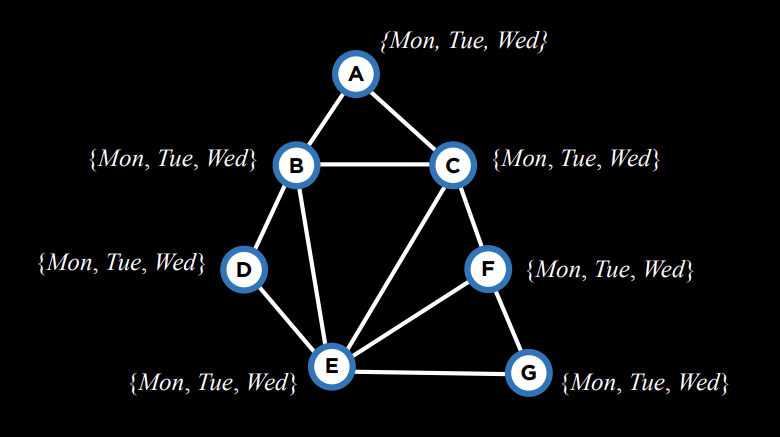

In [15]:
# Define CSP for the schedule example
schedule_csp = {
    'variables': ['A', 'B', 'C', 'D', 'E', 'F', 'G'],
    'domains': {v: ['Mon', 'Tue', 'Wed'] for v in ['A','B','C','D','E','F','G']},
    'neighbors': {
        'A': ['B', 'C'],
        'B': ['A', 'C', 'D', 'E'],
        'C': ['A', 'B', 'E', 'F'],
        'D': ['B', 'E'],
        'E': ['B', 'C', 'D', 'F', 'G'],
        'F': ['C', 'E', 'G'],
        'G': ['E', 'F']
    },
    # Constraints as forbidden pairs (cannot be on same day)
    'constraints': set([
        ('A','Mon','B','Mon'), ('A','Tue','B','Tue'), ('A','Wed','B','Wed'),
        ('B','Mon','C','Mon'), ('B','Tue','C','Tue'), ('B','Wed','C','Wed'),
        ('C','Mon','A','Mon'), ('C','Tue','A','Tue'), ('C','Wed','A','Wed'),
        # Additional constraints for neighbors
        ('B','Mon','D','Mon'), ('B','Tue','D','Tue'), ('B','Wed','D','Wed'),
        ('C','Mon','F','Mon'), ('C','Tue','F','Tue'), ('C','Wed','F','Wed'),
        ('D','Mon','E','Mon'), ('D','Tue','E','Tue'), ('D','Wed','E','Wed'),
        ('E','Mon','F','Mon'), ('E','Tue','F','Tue'), ('E','Wed','F','Wed'),
        ('E','Mon','G','Mon'), ('E','Tue','G','Tue'), ('E','Wed','G','Wed'),
        ('F','Mon','G','Mon'), ('F','Tue','G','Tue'), ('F','Wed','G','Wed'),
        # symmetric constraints
        ('B','Mon','A','Mon'), ('B','Tue','A','Tue'), ('B','Wed','A','Wed'),
        ('C','Mon','B','Mon'), ('C','Tue','B','Tue'), ('C','Wed','B','Wed'),
        ('A','Mon','C','Mon'), ('A','Tue','C','Tue'), ('A','Wed','C','Wed'),
        ('D','Mon','B','Mon'), ('D','Tue','B','Tue'), ('D','Wed','B','Wed'),
        ('F','Mon','C','Mon'), ('F','Tue','C','Tue'), ('F','Wed','C','Wed'),
        ('E','Mon','D','Mon'), ('E','Tue','D','Tue'), ('E','Wed','D','Wed'),
        ('F','Mon','E','Mon'), ('F','Tue','E','Tue'), ('F','Wed','E','Wed'),
        ('G','Mon','E','Mon'), ('G','Tue','E','Tue'), ('G','Wed','E','Wed'),
        ('G','Mon','F','Mon'), ('G','Tue','F','Tue'), ('G','Wed','F','Wed'),
    ])
}

# Solve CSP using Backtracking with MAC
solution_schedule = MAC_BACKTRACK({}, schedule_csp)
print("Schedule Assignment Solution:", solution_schedule)


Schedule Assignment Solution: {'A': 'Mon', 'B': 'Tue', 'C': 'Wed', 'D': 'Mon', 'E': 'Tue', 'F': 'Mon', 'G': 'Wed'}
